In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import pandas as pd
import cv2
import os
import yaml
from tqdm import tqdm

In [2]:
!git clone https://github.com/WongKinYiu/yolov7
!pip install -r yolov7/requirements.txt
!pip uninstall -y wandb
!pip install yt-dlp
!pip install ffmpeg

Cloning into 'yolov7'...
remote: Enumerating objects: 1191, done.
remote: Total 1191 (delta 0), reused 0 (delta 0), pack-reused 1191
Receiving objects: 100% (1191/1191), 74.23 MiB | 27.87 MiB/s, done.
Resolving deltas: 100% (516/516), done.
Found existing installation: wandb 0.12.21
Uninstalling wandb-0.12.21:
  Successfully uninstalled wandb-0.12.21
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=42531e59a55dd35c68841ba09c5b5321e4013724f7e04e37077b749823ab83f5
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg


In [3]:
classes = np.array(['A10','A400M','AG600','AV8B',
        'B1','B2','B52','Be200',
        'C130','C2','C17','C5','E2','E7','EF2000',
        'F117','F14','F15','F16','F18','F22','F35','F4',
        'JAS39','MQ9','Mig31','Mirage2000','P3','RQ4','Rafale',
        'SR71','Su34','Su57',
        'Tu160','Tu95','Tornado',
        'U2','US2', 'V22','XB70','YF23','Vulcan','J20']
)

In [4]:
with open('./yolov7/detect.py') as f:
    data_lines = f.read()
data_lines = data_lines.replace('line_thickness=1', 'line_thickness=4')
with open('./yolov7/detect.py', mode='w') as f:
    f.write(data_lines)
    
    
"""    
with open('./yolov7/utils/loss.py') as f:
    data_lines = f.read()
data_lines = data_lines.replace('from_which_layer.append((torch.ones(size=(len(b),)) * i).to(device)', 'from_which_layer.append((torch.ones(size=(len(b),)) * i).to(device))')
with open('./yolov7/utils/loss.py', mode='w') as f:
    f.write(data_lines)
"""

"    \nwith open('./yolov7/utils/loss.py') as f:\n    data_lines = f.read()\ndata_lines = data_lines.replace('from_which_layer.append((torch.ones(size=(len(b),)) * i).to(device)', 'from_which_layer.append((torch.ones(size=(len(b),)) * i).to(device))')\nwith open('./yolov7/utils/loss.py', mode='w') as f:\n    f.write(data_lines)\n"

In [5]:
csv_paths = glob.glob('../input/militaryaircraftdetectiondataset/dataset/*.csv')
jpg_paths = glob.glob('../input/militaryaircraftdetectiondataset/dataset/*.jpg')
csv_paths.sort()
jpg_paths.sort()
print('number of images:',len(csv_paths))


os.makedirs('./yolov7/data/train/images', exist_ok=True)
os.makedirs('./yolov7/data/train/labels', exist_ok=True)

os.makedirs('./yolov7/data/valid/images', exist_ok=True)
os.makedirs('./yolov7/data/valid/labels', exist_ok=True)

os.makedirs('./yolov7/data/test/images', exist_ok=True)
os.makedirs('./yolov7/data/test/labels', exist_ok=True)

number of images: 12008


In [6]:
# split
for i, (csv_path, jpg_path) in enumerate(tqdm(zip(csv_paths, jpg_paths))):
    annotations = np.array(pd.read_csv(csv_path))
    
    if os.path.basename(csv_path)[0] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'f']:
        #jpg_file_path = './yolov7/data/train/images/' + os.path.basename(jpg_path)
        #txt_file_path = './yolov7/data/train/labels/' + os.path.basename(csv_path)[:-4]+'.txt'
        #shutil.copy(jpg_path, jpg_file_path)
        continue
    elif os.path.basename(csv_path)[0] in ['c', 'd', 'e']:
        jpg_file_path = './yolov7/data/valid/images/' + os.path.basename(jpg_path)
        txt_file_path = './yolov7/data/valid/labels/' + os.path.basename(csv_path)[:-4]+'.txt'
        shutil.copy(jpg_path, jpg_file_path)
    else:
        ##jpg_file_path = './yolov7/data/test/images/' + os.path.basename(jpg_path)
        ##txt_file_path = './yolov7/data/test/labels/' + os.path.basename(csv_path)[:-4]+'.txt'
        #jpg_file_path = './yolov7/data/train/images/' + os.path.basename(jpg_path)
        #txt_file_path = './yolov7/data/train/labels/' + os.path.basename(csv_path)[:-4]+'.txt'
        #shutil.copy(jpg_path, jpg_file_path)
        continue
    
    with open(txt_file_path, mode='w') as f:
        try:
            for annotation in annotations:
                width = annotation[1]
                height = annotation[2]
                class_name = annotation[3]
                xmin = annotation[4]
                ymin = annotation[5]
                xmax = annotation[6]
                ymax = annotation[7]
                x_center = 0.5*(xmin+xmax)
                y_center = 0.5*(ymin+ymax)
                b_width = xmax - xmin
                b_height= ymax - ymin
                class_num = np.where(classes==class_name)[0][0]
                output_string = '{} {} {} {} {}\n'.format(class_num,
                                                        x_center/width,
                                                        y_center/height,
                                                        b_width/width,
                                                        b_height/height)
                f.write(output_string)
        except:
            print(txt_file_path)
            0/0

print('test:',len(glob.glob('./yolov7/data/test/labels/*.txt')))
print('valid:',len(glob.glob('./yolov7/data/valid/labels/*.txt')))
print('train',len(glob.glob('./yolov7/data/train/labels/*.txt')))

12008it [01:28, 136.33it/s]

test: 0
valid: 2236
train 0


In [7]:
classes_string = ', '.join([f'"{c}"' for c in classes])
with open('./yolov7/data/mad.yaml', mode='w') as f:
    yaml_string='train: ./yolov7/data/train\n'\
              + 'val: ./yolov7/data/valid\n'\
              + 'test: ./yolov7/data/test\n'\
              + f'nc: {len(classes)}\n'\
              + f'names: [{classes_string}]'
    f.write(yaml_string)
print(yaml_string)

train: ./yolov7/data/train
val: ./yolov7/data/valid
test: ./yolov7/data/test
nc: 43
names: ["A10", "A400M", "AG600", "AV8B", "B1", "B2", "B52", "Be200", "C130", "C2", "C17", "C5", "E2", "E7", "EF2000", "F117", "F14", "F15", "F16", "F18", "F22", "F35", "F4", "JAS39", "MQ9", "Mig31", "Mirage2000", "P3", "RQ4", "Rafale", "SR71", "Su34", "Su57", "Tu160", "Tu95", "Tornado", "U2", "US2", "V22", "XB70", "YF23", "Vulcan", "J20"]


In [8]:
hyp = {
    'lr0': 0.0002,  # initial learning rate (SGD=1E-2, Adam=1E-3)
    'lrf': 0.001,  # final OneCycleLR learning rate (lr0 * lrf)
    'momentum': 0.937,  # SGD momentum/Adam beta1
    'weight_decay': 0.0005,  # optimizer weight decay 5e-4
    'warmup_epochs': 2.0,  # warmup epochs (fractions ok)
    'warmup_momentum': 0.8,  # warmup initial momentum
    'warmup_bias_lr': 0.0001,  # warmup initial bias lr
    'box': 0.05,  # box loss gain
    'cls': 0.3,  # cls loss gain
    'cls_pw': 1.0,  # cls BCELoss positive_weight
    'obj': 0.7,  # obj loss gain (scale with pixels)
    'obj_pw': 1.0,  # obj BCELoss positive_weight
    'iou_t': 0.20,  # IoU training threshold
    'anchor_t': 4.0,  # anchor-multiple threshold
    # anchors: 3  # anchors per output layer (0 to ignore)
    'fl_gamma': 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
    'hsv_h': 0.015,  # image HSV-Hue augmentation (fraction)
    'hsv_s': 0.7,  # image HSV-Saturation augmentation (fraction)
    'hsv_v': 0.4,  # image HSV-Value augmentation (fraction)
    'degrees': 0.5,  # image rotation (+/- deg)
    'translate': 0.25,  # image translation (+/- fraction)
    'scale': 0.45,  # image scale (+/- gain)
    'shear': 0.5,  # image shear (+/- deg)
    'perspective': 0.0,  # image perspective (+/- fraction), range 0-0.001
    'flipud': 0.15,  # image flip up-down (probability)
    'fliplr': 0.5,  # image flip left-right (probability)
    'mosaic': 0.8,  # image mosaic (probability)
    'mixup': 0.35,  # image mixup (probability)
    'copy_paste': 0,  # image copy paste (probability)
    'paste_in': 0,  # image copy paste (probability), use 0 for faster training
    'loss_ota': 1, # use ComputeLossOTA, use 0 for faster training
}
with open('./yolov7/data/hyp.yaml', 'w') as f:
    yaml.dump(hyp, f)

In [9]:
# YOLOv-W6
os.makedirs('./yolov7/checkpoints', exist_ok=True)
shutil.copy('../input/yolov7-military-plane/yolov7-w6-best.pt', './yolov7/checkpoints/yolov7-w6.pt')

'./yolov7/checkpoints/yolov7-w6.pt'

In [10]:
"""
# colab A100
!python ./yolov7/train_aux.py \
  --batch-size 20 \
  --img-size 1280 \
  --epochs 55 \
  --name yolov7_mad_12 \
  --adam \
  --data ./yolov7/data/mad.yaml \
  --cfg ./yolov7/cfg/training/yolov7-w6.yaml \
  --weights ./yolov7/checkpoints/yolov7-w6.pt \
  --v5-metric \
  --hyp ./yolov7/data/hyp.yaml
"""

'\n# colab A100\n!python ./yolov7/train_aux.py   --batch-size 20   --img-size 1280   --epochs 55   --name yolov7_mad_12   --adam   --data ./yolov7/data/mad.yaml   --cfg ./yolov7/cfg/training/yolov7-w6.yaml   --weights ./yolov7/checkpoints/yolov7-w6.pt   --v5-metric   --hyp ./yolov7/data/hyp.yaml\n'

In [11]:
!python ./yolov7/test.py \
  --batch-size 24 \
  --img-size 1280 \
  --name yolov7_mad_12 \
  --data ./yolov7/data/mad.yaml \
  --weights ./yolov7/checkpoints/yolov7-w6.pt \
  --v5-metric

Namespace(augment=False, batch_size=24, conf_thres=0.001, data='./yolov7/data/mad.yaml', device='', exist_ok=False, img_size=1280, iou_thres=0.65, name='yolov7_mad_12', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', v5_metric=True, verbose=False, weights=['./yolov7/checkpoints/yolov7-w6.pt'])
Fusing layers... 
IAuxDetect.fuse
/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

val: Scanning 'yolov7/data/valid/labels' images and labels... 2236 found, 0 miss
Testing with YOLOv5 AP metric...
               Class      Images      Labels        

In [12]:
!ls ./runs/test/yolov7_mad_12

F1_curve.png  confusion_matrix.png    test_batch1_pred.jpg
PR_curve.png  test_batch0_labels.jpg  test_batch2_labels.jpg
P_curve.png   test_batch0_pred.jpg    test_batch2_pred.jpg
R_curve.png   test_batch1_labels.jpg


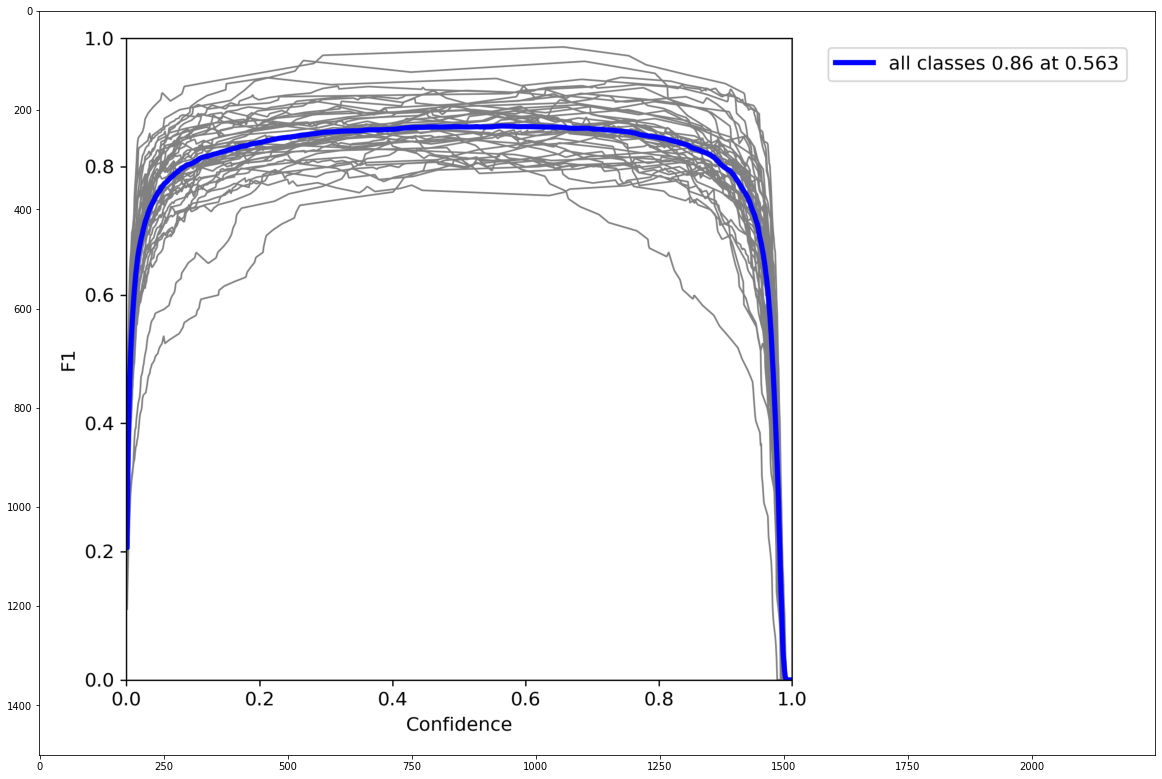

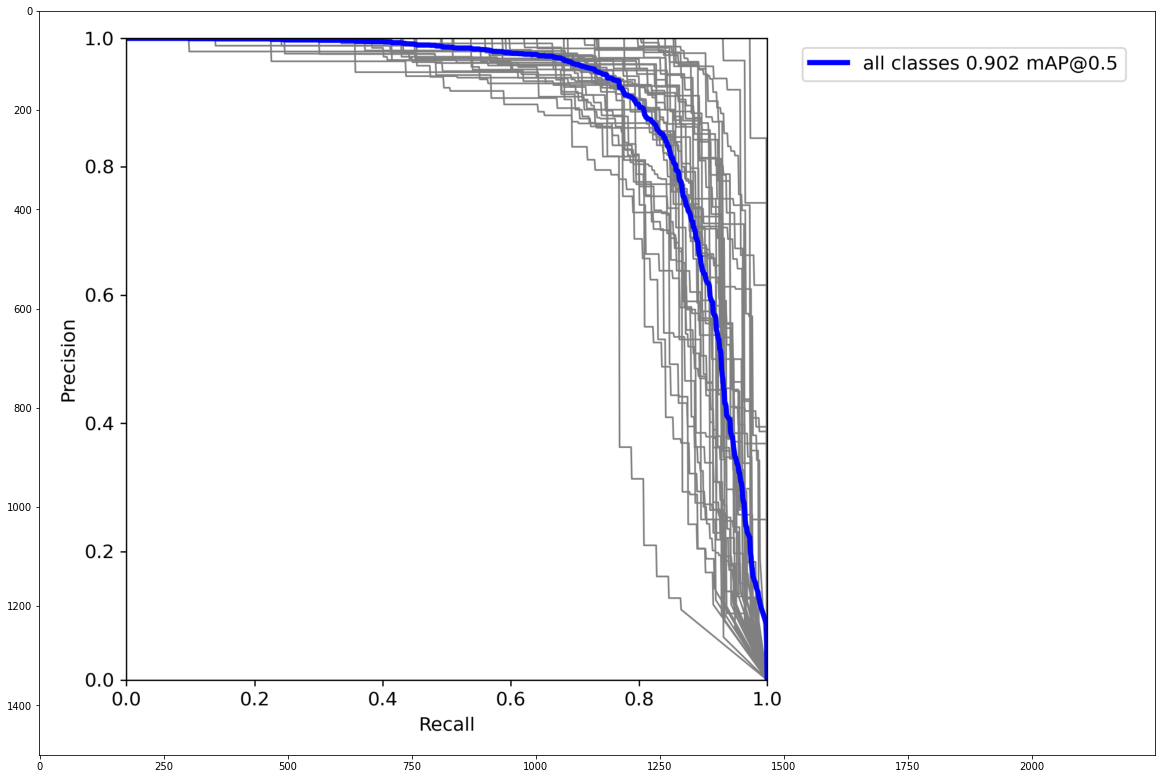

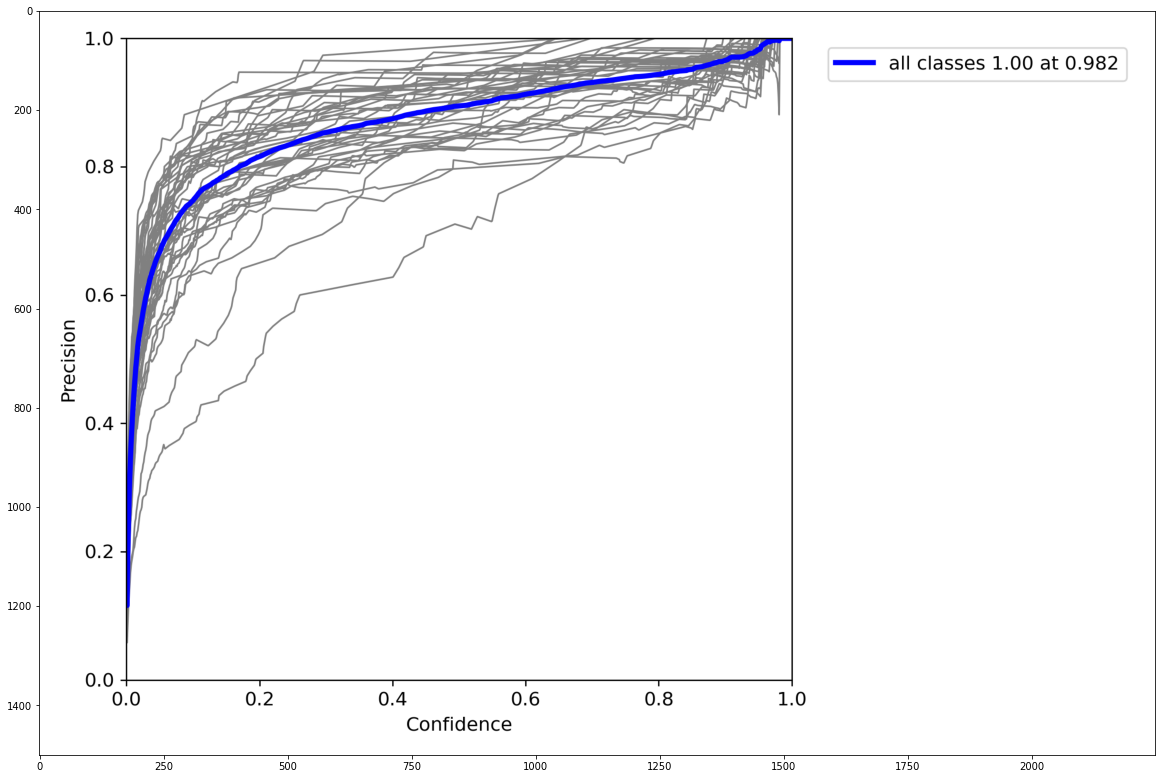

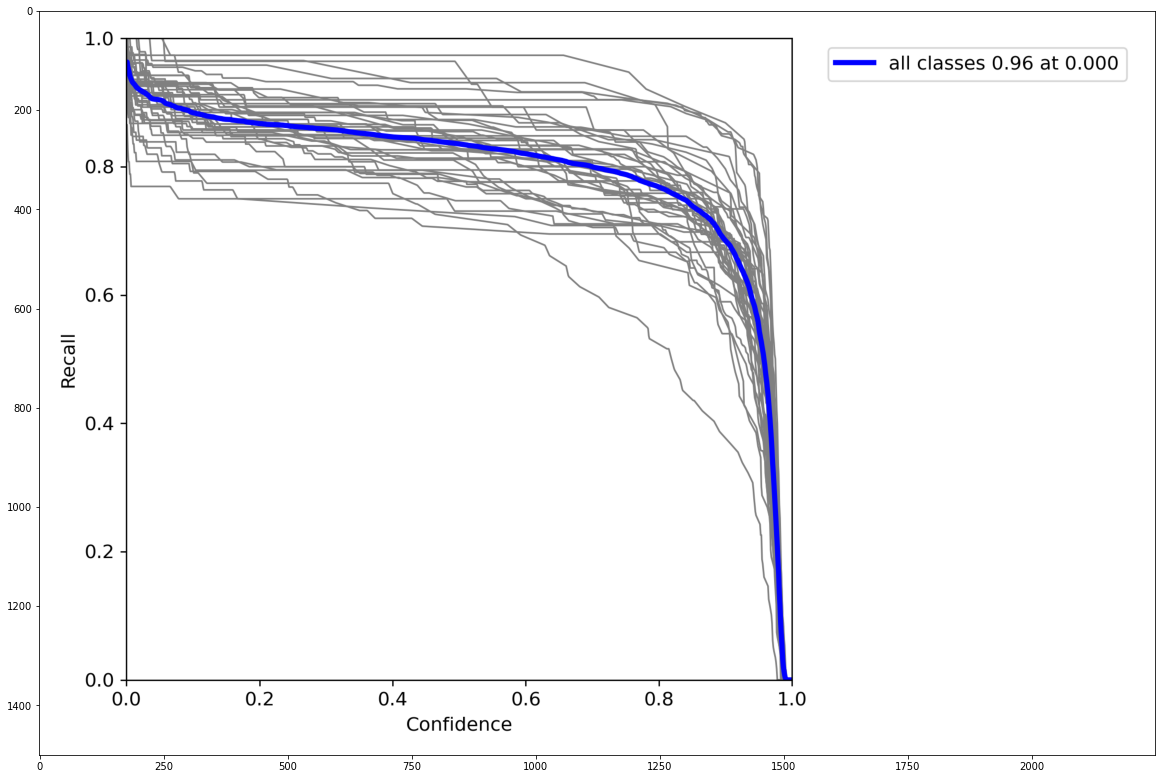

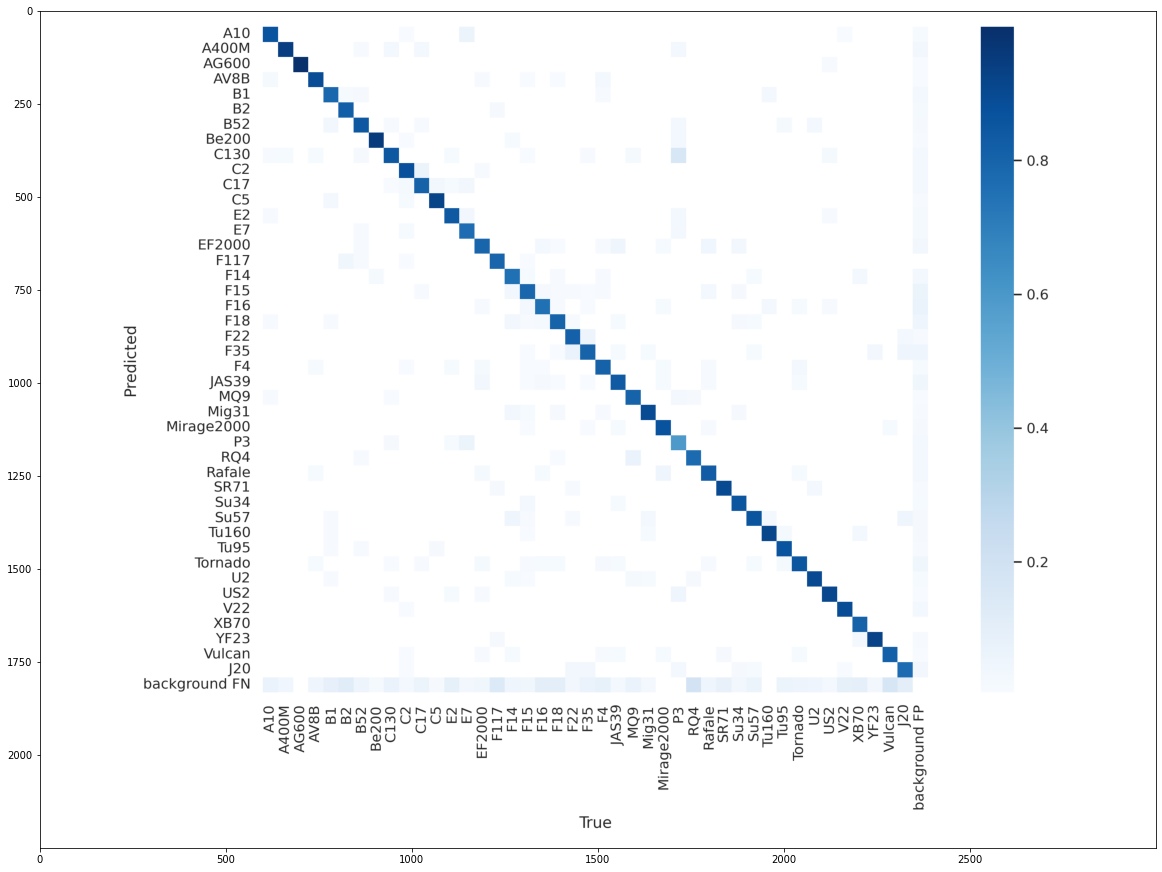

In [13]:
for path in sorted(glob.glob('./runs/test/yolov7_mad_12/*.png')):
    image = cv2.imread(path)[:,:,::-1]
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    plt.show()

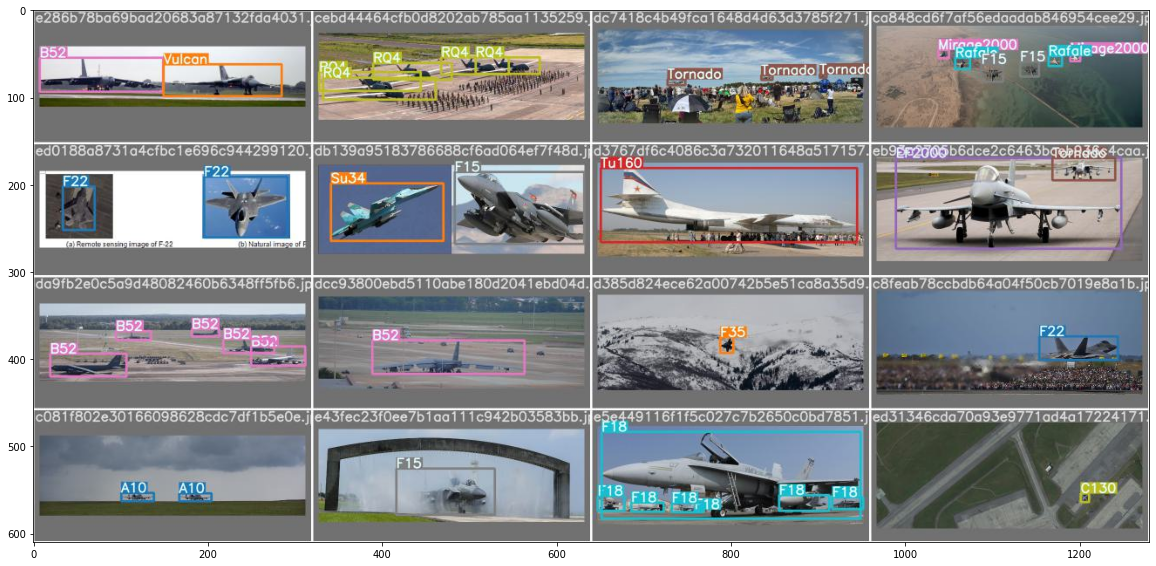

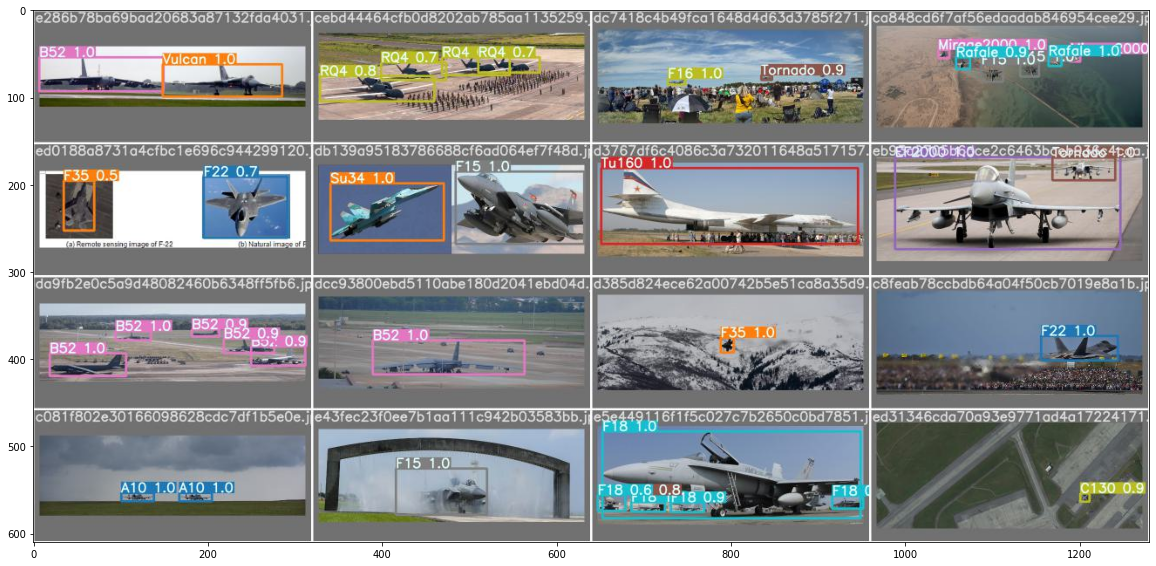

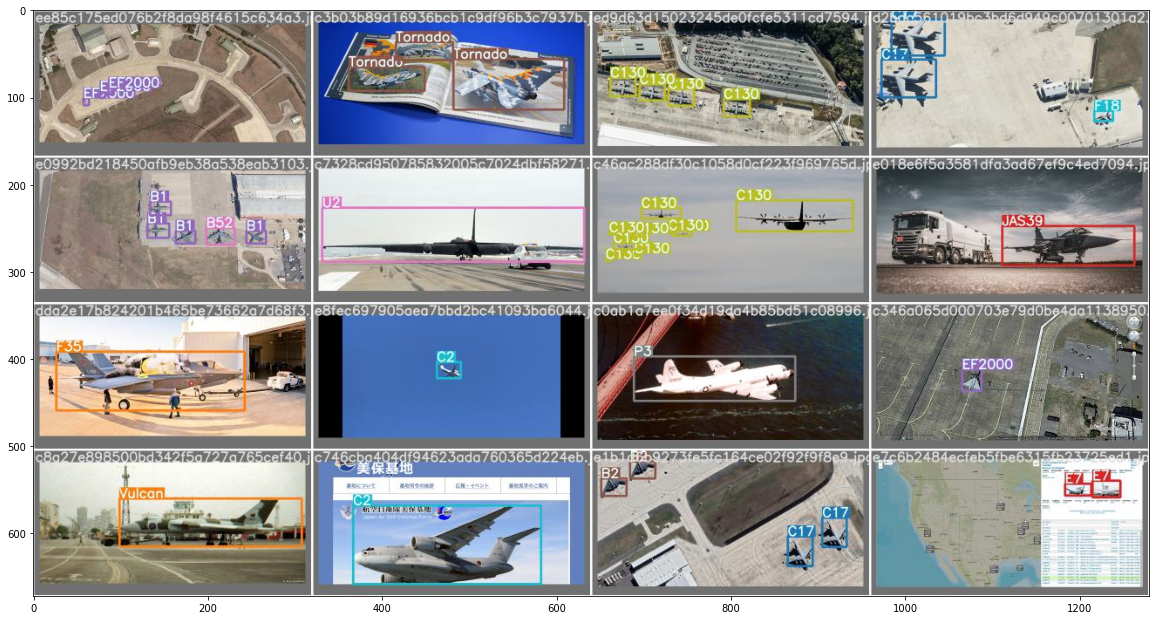

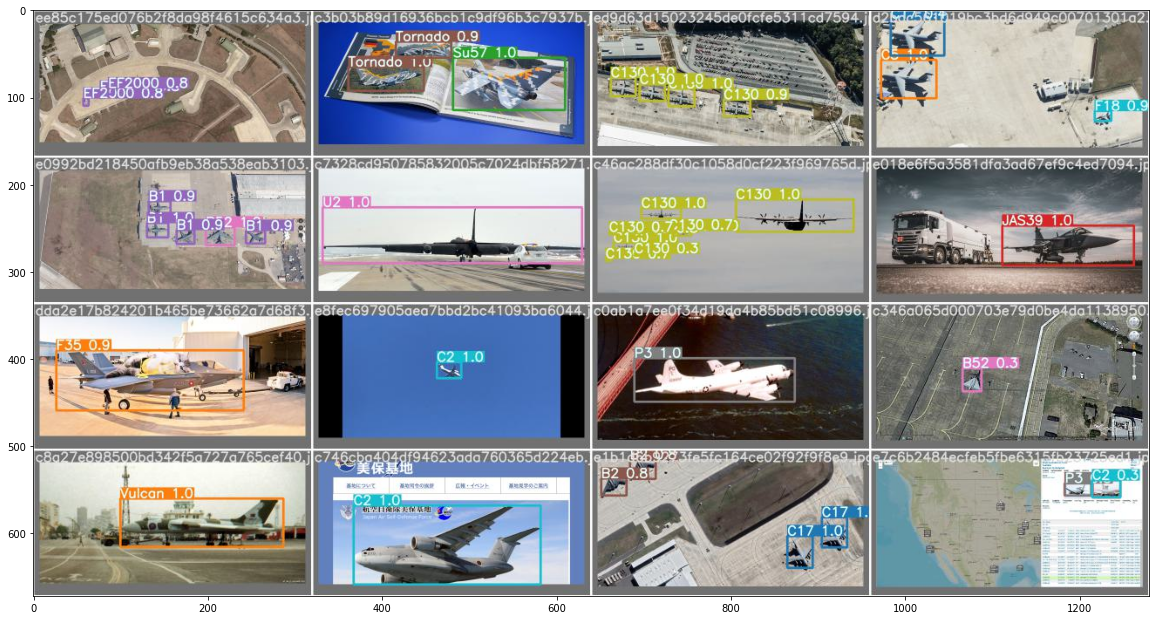

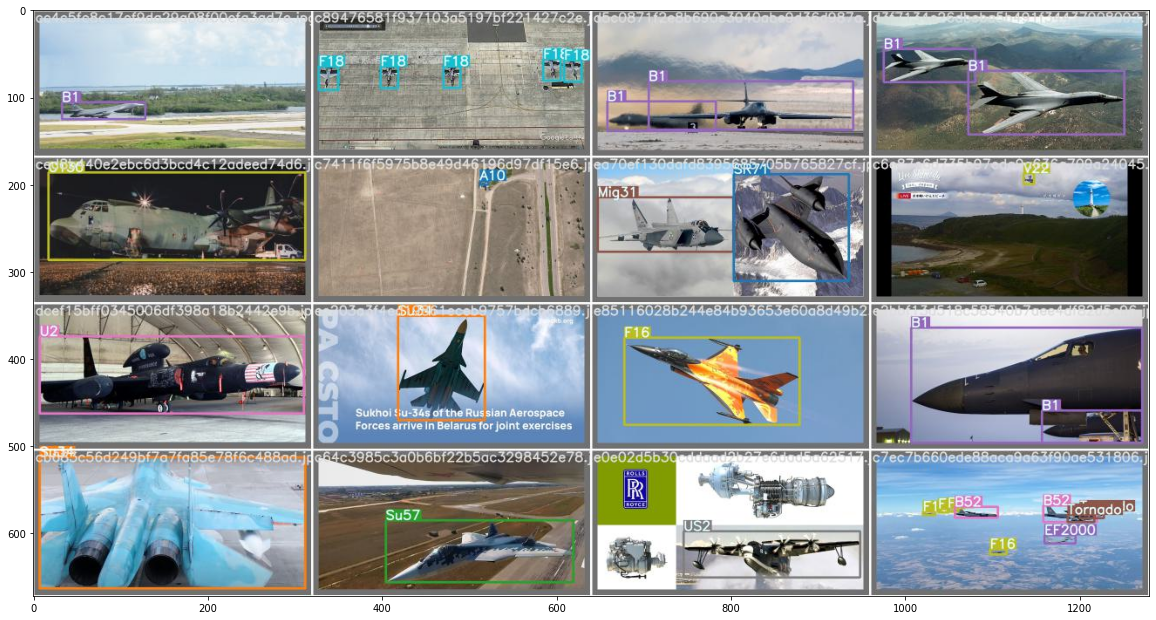

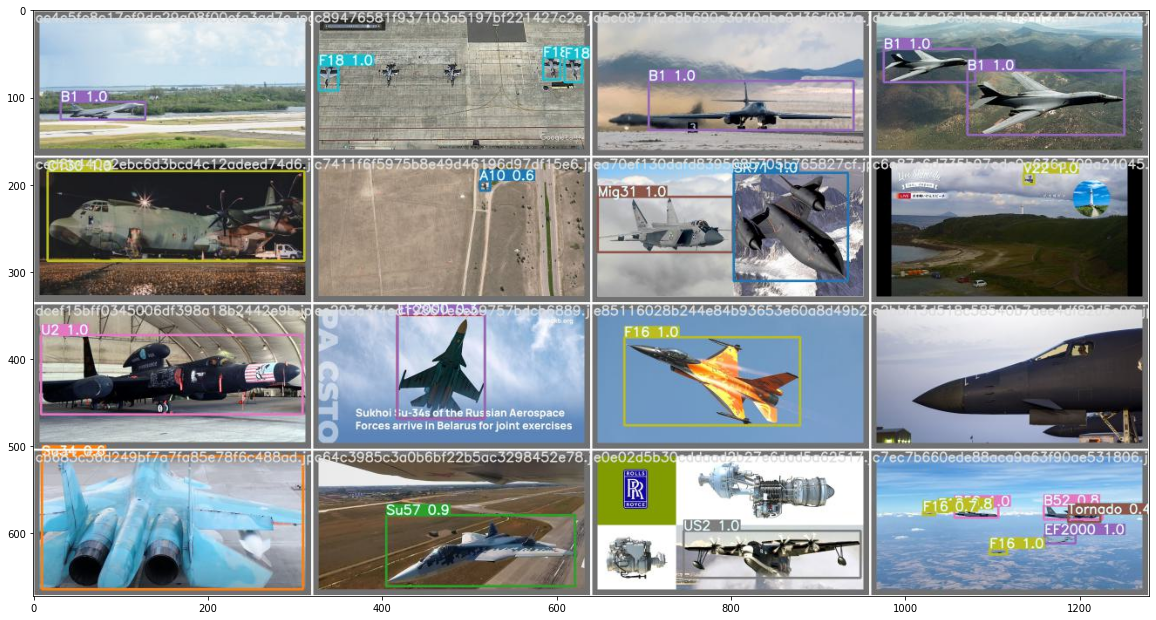

In [14]:
for path in sorted(glob.glob('./runs/test/yolov7_mad_12/*.jpg')):
    image = cv2.imread(path)[:,:,::-1]
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    plt.show()

In [15]:
#!yt-dlp -F https://www.youtube.com/watch?v=jdXWqG42S8c

In [16]:
#!yt-dlp -f 137 -o video.mp4  https://www.youtube.com/watch?v=jdXWqG42S8c

In [17]:
#/content/runs/train/military_aircraft_detection4/weights/best.pt \
"""
!python ./yolov7/detect.py \
                         --weights ./yolov7/checkpoints/yolov7-w6.pt \
                         --img-size 1280 \
                         --conf-thres 0.3 \
                         --iou-thres 0.8 \
                         --augment \
                         --agnostic-nms \
                         --source ./video.mp4 \
                         --name infer_video
"""

'\n!python ./yolov7/detect.py                          --weights ./yolov7/checkpoints/yolov7-w6.pt                          --img-size 1280                          --conf-thres 0.3                          --iou-thres 0.8                          --augment                          --agnostic-nms                          --source ./video.mp4                          --name infer_video\n'

In [18]:
#!ffmpeg -i ./runs/detect/infer_video/video.mp4 -vf scale=1024:-1 ./runs/detect/infer_video/video2.mp4

In [19]:
#from IPython.display import Video
#Video('./runs/detect/infer_video/video2.mp4', width=1024)

In [20]:
!rm -r ./yolov7
!rm ./traced_model.pt
!rm ./video.mp4
!rm ./runs/detect/infer_video/video.mp4

rm: cannot remove './video.mp4': No such file or directory
rm: cannot remove './runs/detect/infer_video/video.mp4': No such file or directory
